# Анализ поведения пользователей мобильного приложения

Задачи проекта

1. Изучение воронки продаж - анализ конверсий на разных этапах воронки.
2. Анализ результатов А/Б-теста - оценка влияния изменения интерфейса на поведение пользователей.

На этапе анализа воронки продаж требуется проанализировать поведение пользователей мобильного приложения стартапа, занимающегося продажей продуктов питания. Необходимо выяснить, как пользователи проходят путь от главной страницы приложения до успешной оплаты покупки, на каких этапах высокая конверсия, а на каких - низкая.

На этапе анализа результатов А/Б-теста необходимо оценить влияние изменений в интерфейсе приложения на пользовательский опыт - дизайнеры предложили поменять шрифты во всём приложении. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Требуется выяснить, имеются ли статистически значимые различия в конверсии пользователей между группами теста.

Данные для анализа - логи пользователей мобильного приложения.

## Считывание и обзор данных

Подключим необхоимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import math as mth
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

Считаем данные

In [2]:
try:
    logs = pd.read_csv('datasets/logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

Проведем обзор данных

In [3]:
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Таблица содержит 244126 записей.

Каждая запись - это действие пользователя в приложении, или событие.

Для каждого события задано четыре параметра:

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента.

Из имеющихся данных известно, что к исследуемому А/Б-тесту относятся три группы экспериментов: 246 и 247 — контрольные группы, 248 — экспериментальная.

Явных пропусков в данных нет.

Перейдем к предварительной обработке данных.

## Предобработка данные

Произведем некоторые изменения в исходных даннх для более удобной работы с ними.

### Названия столбцов

Заменим названия столбцов для более удобного обращения.

In [5]:
logs.columns = ['event', 'user', 'timestamp', 'group']

### Пропуски и дубликаты

Определим наличие пропусков и дубликатов, оценим их количество и удалим при наличии.

Сначала проверим явные дубликаты.

In [6]:
logs[logs.duplicated()]['user'].count()

413

Имеем 413 дубликатов. Удалим их.

In [7]:
logs = logs.drop_duplicates().reset_index(drop=True)

In [8]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      243713 non-null  object
 1   user       243713 non-null  int64 
 2   timestamp  243713 non-null  int64 
 3   group      243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


Проверим наличие неявных дубликатов и пропусков в столбцах `'event'` и `'group'`.

In [9]:
logs['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [10]:
logs['group'].unique()

array([246, 248, 247], dtype=int64)

Неявных пропусков и дубликатов в полях `'event'` и `'group'` не выявлено.

### Типы данных

Преобразуем формат данных в поле `'group'`, чтобы занимали меньше места.

In [11]:
logs['group'] = logs['group'].astype('int16')

In [12]:
logs['group'].unique()

array([246, 248, 247], dtype=int16)

Добавим столбцы с датой и временем события и отдельно с датой события

In [13]:
logs['dt'] = pd.to_datetime(logs['timestamp'], unit='s')
logs['date'] = pd.to_datetime(logs['dt'].dt.date)

In [14]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   user       243713 non-null  int64         
 2   timestamp  243713 non-null  int64         
 3   group      243713 non-null  int16         
 4   dt         243713 non-null  datetime64[ns]
 5   date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int16(1), int64(2), object(1)
memory usage: 9.8+ MB


In [15]:
logs.head()

,event,user,timestamp,group,dt,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


В ходе предобработки провели следующие манипуляции с данными:

- Заменили названия столбцов для удобства обращения к ним;
- Проверили пропуски и дубликаты;
- Внесли коррективы в типы данных;
- Добавили столбец даты и времени и отдельный столбец дат.

## Исследование данных

### Обзор данных

Изучим имеющиеся данные

In [16]:
log_len = logs.shape[0]
events_unique = logs['event'].nunique()
users_unique = logs['user'].nunique()
min_date = logs['dt'].min()
max_date = logs['dt'].max()
 
print(f'''В логах хранятся записи о {events_unique} типах игровых событий.
Всего - {log_len} записей
\t для {users_unique} пользователей 
\t за период с {min_date}
\t\t по {max_date}''')

В логах хранятся записи о 5 типах игровых событий.
Всего - 243713 записей
	 для 7551 пользователей 
	 за период с 2019-07-25 04:43:36
		 по 2019-08-07 21:15:17


Оценим распределение событий по пользователям.

In [17]:
events_per_user = logs.groupby('user', as_index=False).agg(events = ('event', 'count'))
events_per_user['events'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: events, dtype: float64

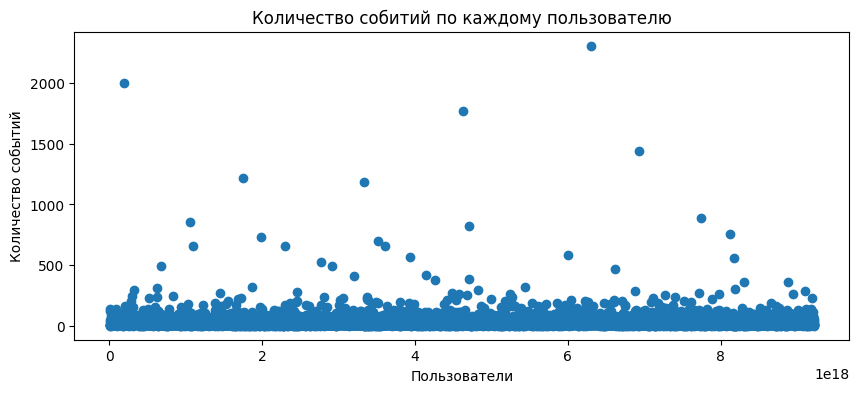

In [18]:
plt.figure(figsize=(10,4))
plt.scatter(events_per_user['user'], events_per_user['events'])
plt.title('Количество собитий по каждому пользователю')
plt.xlabel('Пользователи')
plt.ylabel('Количество событий')
plt.show()

В среднем на одного пользователя приходится 32 события. Медианное значение количества событий на одного пользователя - 20. Большинство пользователей совершает до 200 действий. Но есть несколько фанатов приложения, совершивших более 1000 действий.

### Анализ распределения данных по времени

Изучим распределение событий в логах по наблюдаемому периоду.

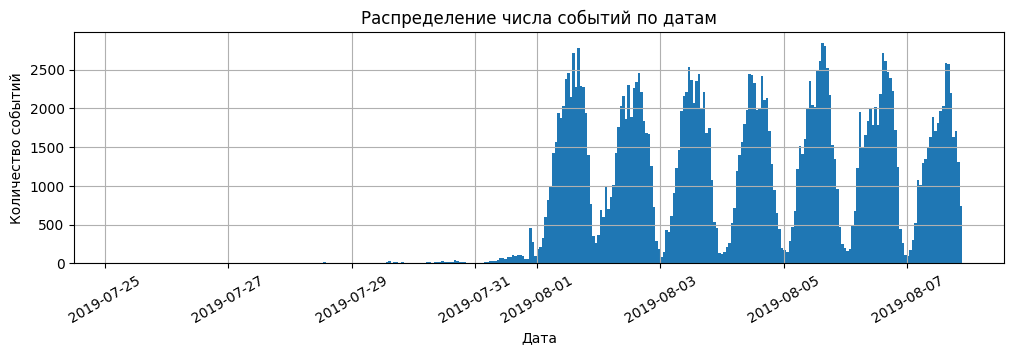

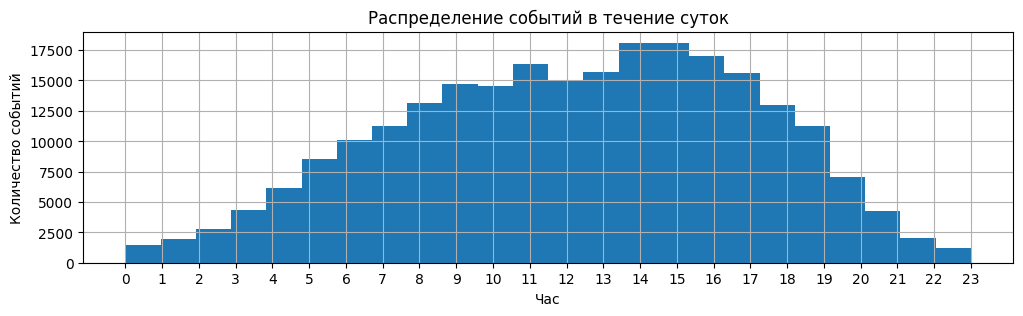

In [19]:
logs['dt'].hist(figsize=(12, 3), bins=(14*24), xrot=30)
plt.title('Распределение числа событий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

plt.title('Распределение событий в течение суток')
logs['dt'].dt.hour.hist(bins=24, figsize=(12, 3))
plt.xticks(range(0, 24))
plt.xlabel('Час')
plt.ylabel('Количество событий')
plt.show()

По гистограмме видно, как 01.08.2019 резко увеличивается количество записей за каждый день наблюдений. Возможно, это свилетествует о том, что записи до 1 августа - не полные. Так же, мы видим, что основная активность пользователей наблюдается в денвное время.

Примем 01.08.2019 за начальную дату отсчета, чтобы убрать из логов неполные данные за более ранний период.

In [20]:
real_min_date = pd.to_datetime('2019-08-01')

### Фильтрация данных по времени

Проверим, сколько событий будет отброшено фильтром по дате.

In [21]:
droped_records_count = (logs[logs['date'] < real_min_date]['date'].count(), 
                  round(logs[logs['date'] < real_min_date]['date'].count()  / logs.shape[0] * 100, 2))

In [22]:
droped_records_count

(2826, 1.16)

Будет удалено 2826 записей, что соствляет 1,16% от общего числа записей в логах.

Проверим, сколько пользователей будет отброшено фильтром по дате.

In [23]:
droped_users_count = (users_unique - logs[logs['date'] >= real_min_date]['user'].nunique(), 
                     round((users_unique - logs[logs['date'] >= real_min_date]['user'].nunique()) /
                           users_unique * 100, 2))

In [24]:
droped_users_count

(17, 0.23)

Будут удалены записи о 17 пользователях, что составит 0,23% от общего числа пользователей.

Отфильтруем данные, удалив записи до принятой начальной даты.

In [25]:
logs_filtered = logs[logs['date'] >= real_min_date].reset_index(drop=True)

In [26]:
logs_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240887 entries, 0 to 240886
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      240887 non-null  object        
 1   user       240887 non-null  int64         
 2   timestamp  240887 non-null  int64         
 3   group      240887 non-null  int16         
 4   dt         240887 non-null  datetime64[ns]
 5   date       240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int16(1), int64(2), object(1)
memory usage: 9.6+ MB


Изучили распределение событий по пользователям и времени. Ограничили временной промежуток, удалив старые неполные данные.

### Проверка групп теста

Убедимся, что группы теста не пересекаются - разные собития для одних и тех же пользователей не должны попадать в разные группы теста.

In [27]:
users_246 = pd.DataFrame(logs_filtered[logs_filtered['group'] == 246]['user'].unique(), columns=['user'])
users_247 = pd.DataFrame(logs_filtered[logs_filtered['group'] == 247]['user'].unique(), columns=['user'])
users_248 = pd.DataFrame(logs_filtered[logs_filtered['group'] == 248]['user'].unique(), columns=['user'])

In [28]:
if (len(users_246.merge(users_247, on='user')) != 0)\
or (len(users_246.merge(users_248, on='user')) != 0)\
or (len(users_247.merge(users_248, on='user')) != 0):
    print('Группы пересекаются.')
else:
    print('Группы не пересекаются.')

Группы не пересекаются.


In [29]:
# Альтернативный вариант проверки пересечений
(
logs_filtered
    .groupby('user')
    .agg({'group' : 'nunique'})
    .query('group>1')
)

,group
user,


Проверим количество пользователей в группах теста.

In [30]:
test_groups = dict()

for group in logs['group'].unique():
    test_groups[group] = logs_filtered[logs_filtered['group'] == group]['user'].nunique()
    
test_groups = pd.DataFrame(data=test_groups.values(), index=test_groups.keys())
test_groups = test_groups.sort_index().reset_index()
test_groups.columns = ['group', 'users_cnt']
test_groups['users_percent'] = round(test_groups['users_cnt'] / test_groups['users_cnt'].sum() * 100, 2)

In [31]:
test_groups

,group,users_cnt,users_percent
0,246,2484,32.97
1,247,2513,33.36
2,248,2537,33.67


Убедились в том, что сохранили данные по всем группам теста. В оставшихся данных имеем в каждой группе около 2500 пользователей. Пользователи разделены почти поровну, но в тестовой группе (248) участников немного больше, чем в контролольных - 2537, или 33,67% от общего числа пользователей.

## Анализ воронки событий

### Обзор событий в логах

Изучим, какие события есть в логах и как часто они встречаются, отсортируем их по частоте.

In [32]:
events = (
    logs_filtered.groupby('event')
    .agg({'timestamp': 'count'})
    .rename(columns={'timestamp': 'event_cnt'})
    .sort_values('event_cnt', ascending=False)
    .reset_index()
)

In [33]:
events

,event,event_cnt
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


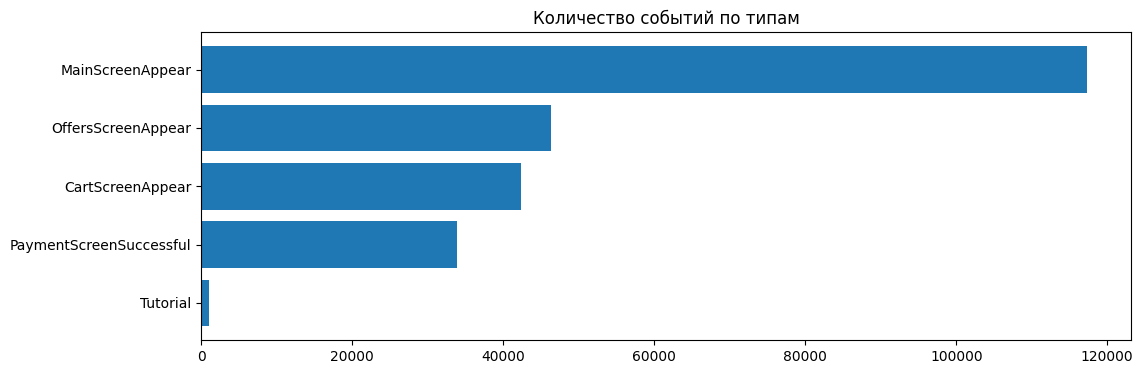

In [34]:
plt.figure(figsize=(12,4))
plt.barh(events['event'], events['event_cnt'])
plt.gca().invert_yaxis()
plt.title('Количество событий по типам')
plt.show()

По графику и таблице видим распределение событий по их количеству за изучаемый промежуток времени.

Посчитаем, сколько пользователей совершали каждое из этих событий. Посчитаем долю пользователей, которые хоть раз совершили каждое из событий. Отсортируем события по числу пользователей. 

In [35]:
events_funnel = (
    logs_filtered.groupby('event')
    .agg({'user': 'nunique'})
    .rename(columns={'user': 'users_cnt'})
    .sort_values('users_cnt', ascending=False)
    .reset_index()
)

In [36]:
events_funnel['users_part'] = round(events_funnel['users_cnt'] / logs_filtered['user'].nunique(), 4)

In [37]:
events_funnel

,event,users_cnt,users_part
0,MainScreenAppear,7419,0.9847
1,OffersScreenAppear,4593,0.6096
2,CartScreenAppear,3734,0.4956
3,PaymentScreenSuccessful,3539,0.4697
4,Tutorial,840,0.1115


По всей видимости, событие `Tutorial` (Учебник) не входит в воронку, так как к нему переходит очень малая доля пользователей (Значит, этот этап не является обязательным при пользовании приложением). В таком случае последовательная цепочка событий в приложении может выглядить так: 

1. Главный экран (`MainScreenAppear`) -> 
2. Экран с предложениями (`OffersScreenAppear`) -> 
3. Экран с корзиной товаров (`CartScreenAppear`) -> 
4. Экран успешной оплаты (`PaymentScreenSuccessful`).

### Построение воронки событий

Построим воронку событий приложения по количеству пользователей на каждом этапе.

In [38]:
events_funnel = events_funnel[events_funnel['event'] != 'Tutorial']

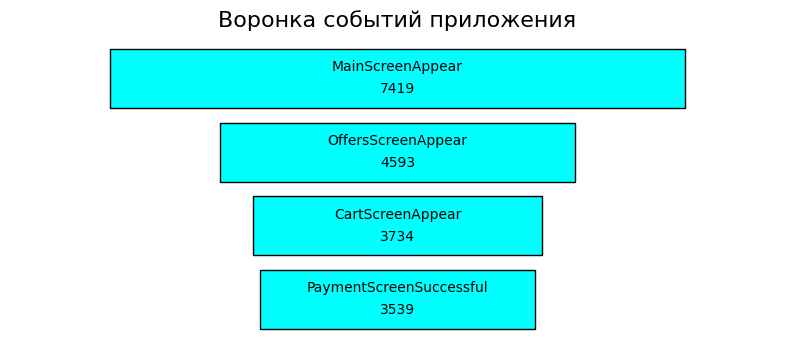

In [39]:
y = [4,3,2,1]
x = events_funnel['users_cnt']
labels = events_funnel['event']
x_max = 10000
x_min = 0
x_range = x_max - x_min

plt.subplots(1, figsize=(10,4))
for idx, val in enumerate(x):
    left = (x_range - val)/2
    plt.barh(y[idx], x[idx], left = left, height=0.8, color='cyan', edgecolor='black')
    # label
    plt.text(5000, y[idx]+0.1, labels[idx], ha='center', fontsize=10, color='black')
    # value
    plt.text(5000, y[idx]-0.2, x[idx], ha='center', fontsize=10, color='black')
    
plt.xlim(x_min, x_max)
plt.axis('off')
plt.title('Воронка событий приложения', loc='center', fontsize=16, color='black')
plt.show()

### Анализ конверсии

Посчитаем, какая доля пользователей проходит на каждый последующий шаг воронки относительно предыдущего.

In [40]:
events_funnel['conversion_step'] = (
    events_funnel['users_cnt'].div(events_funnel['users_cnt'].shift(1)).fillna(1).round(4)
)

events_funnel['conversion_total'] = (
    round(events_funnel['users_cnt'] / events_funnel.iloc[0]['users_cnt'], 4)
)

events_funnel['users_change'] = (
    events_funnel['users_cnt'].pct_change().fillna(0).round(4)
)

In [41]:
events_funnel

,event,users_cnt,users_part,conversion_step,conversion_total,users_change
0,MainScreenAppear,7419,0.9847,1.0000,1.0000,0.0000
1,OffersScreenAppear,4593,0.6096,0.6191,0.6191,-0.3809
2,CartScreenAppear,3734,0.4956,0.8130,0.5033,-0.1870
3,PaymentScreenSuccessful,3539,0.4697,0.9478,0.4770,-0.0522


Как видно из таблицы, больше всего пользователей теряется на переходе от `MainScreenAppear` к `OffersScreenAppear` - более 38%. Самая лучшая конверсия - из этапа `CartScreenAppear` в этап `PaymentScreenSuccessful` - 94,78%.

От первого события до обплаты доходят 46,97% пользователей.

Около 1,5% пользователей пропускают этап `MainScreenAppear`.

По всей видимости, пользователям нравятся предложения компании, и они готовы совершать покупки. Однако, большинство пользователей отсеивается на этапе перехода с главного экрана к экрану с предложениями. Видимо, с главным экраном имеются какие-то проблемы, усложняющие пользование приложеним.

## Анализ результатов А/Б-теста

### Обзор данных об эксперименте

Ранее мы убедились в валидном распределении пользователей и в отсутствии пересечений между группами.

In [42]:
test_groups

,group,users_cnt,users_percent
0,246,2484,32.97
1,247,2513,33.36
2,248,2537,33.67


Изучем воронку событий в разрезе групп.

In [43]:
funnel_group = (
    logs_filtered[logs_filtered['event'] != 'Tutorial']
    .pivot_table(index='event', columns='group', values='user', aggfunc='nunique')
    .sort_values(246, ascending=False)
    .reset_index()
)
funnel_group['246_conversion'] = round(funnel_group[246] /
                                 logs_filtered[logs_filtered['group'] == 246]['user'].nunique() * 100, 2)
funnel_group['247_conversion'] = round(funnel_group[246] /
                                 logs_filtered[logs_filtered['group'] == 247]['user'].nunique() * 100, 2)
funnel_group['248_conversion'] = round(funnel_group[246] /
                                 logs_filtered[logs_filtered['group'] == 248]['user'].nunique() * 100, 2)


In [44]:
funnel_group

group,event,246,247,248,246_conversion,247_conversion,248_conversion
0,MainScreenAppear,2450,2476,2493,98.63,97.49,96.57
1,OffersScreenAppear,1542,1520,1531,62.08,61.36,60.78
2,CartScreenAppear,1266,1238,1230,50.97,50.38,49.90
3,PaymentScreenSuccessful,1200,1158,1181,48.31,47.75,47.30


Как видно из таблицы, средние показатели конверсии на всех этапах воронки соизмеримы между группами, но значения в группе 248 немного ниже. Перейдем к рассчету статистической значимости наблюдаемых отличий.

### Анализ результатов A/B-теста

В рассматриваемом тесте будем проверять гипотезу о равенстве пропорций. Для этого применим z-тест.

Сначала проведем А/А-тест и убедимся в отсутствии статистически значимых различий между контрольными группами (246 и 247), что позволит нам убедиться в коректности разделения пользователей на группы теста. Затем перейдем к А/Б-тестированию и проверим гипотизу о влиянии изменения шрифта в приложении на конверсию.

Предложен следующий порядок проверки равенства долей:
1. между контрольными группами (А/А - тест между группами 246 и 247),
2. попарно между каждой из контрольных групп и тестовой группой (246 и 248, 247 и 248),
3. между объединенной контрольной группой и тестовой группой (246 + 247 и 248).

Таким образом будем иметь четыре попарных сравнения. И в каждом из попарных сравнений мы будем проводить по четыре теста (для каждого из этапов воронки). Следовательно для всех тестов введем поправку для критерия значимости с коэффициентом равным 16 (4 шага * 4 попарных сравнения). Применим для расчетов метод Шидака, сохраняющий групповую вероятность ошибки первого рода меньше альфа, но повышающий мощность теста.

Обозначим нулевую и альтернативную гипотезы для каждого из попарных сравнений:

    Н0: доли посетителей на каждом из этапов воронки между группами теста одинаковы.
    Н1: доли посетителей на каждом из этапов воронки между группами теста различаются.
    
Уровень значимости примем равный 5%

In [45]:
alpha = 0.05
ratio = 16

Для удобства оформим расчеты в виде функции.

In [46]:
def z_test(sample1, sample2, event, alpha, ratio):

    # скорректированный уровень значимости
    alpha_corr = 1 - (1 - alpha) ** (1 / ratio)
    
    # размеры сравниваемых групп
    trials = np.array([sample1['user'].nunique(), sample2['user'].nunique()])
    # число пользователей, дошедших до события event в каждой из групп
    successes = np.array([sample1[sample1['event'] == event]['user'].nunique(),
                          sample2[sample2['event'] == event]['user'].nunique()])
    
    # пропорции успехов в группах
    p1 = successes[0] / trials[0]
    p2 = successes[1] / trials[1]
    # пропорции успехов в комбинированном датасэте
    p_comb = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # разница пропорций в датасэтах
    difference = p1 - p2
    
    # считаем z-статистику
    z_value = difference / mth.sqrt(p_comb * (1 - p_comb) * (1 / trials[0] + 1 / trials[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2 # двусторонний тест
    print('Событие:', event)
    print('p-значение: ', p_value)

    if p_value < alpha_corr:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными',
        )
    print()

#### А/А-тест

Проверим, есть ли статистически значимая разница между группами 246 и 247.

In [47]:
for event in funnel_group['event'].unique():
    
    z_test(
        logs_filtered[logs_filtered['group'] == 246], 
        logs_filtered[logs_filtered['group'] == 247], 
        event=event, alpha=alpha, ratio=ratio
    )

Событие: MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



А/А-тест указывает на отсутствие между группами статистически значимой разницы долей пользователей на всех этапах воронки. Это указвает на корректность разделения пользователей на группы для теста.

Можем приступать к анализу результатов А/Б-теста.

#### А/B-тест попарно с каждой из контрольных групп

Проверим, есть ли статистически значимая разница между группами 246 и 248.

In [48]:
for event in funnel_group['event'].unique():
    
    z_test(
        logs_filtered[logs_filtered['group'] == 246], 
        logs_filtered[logs_filtered['group'] == 248], 
        event=event, alpha=alpha, ratio=ratio
    )

Событие: MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При заданном уровне значимости у нас нет основания отвергать нулевую гипотезу. Мы не можем считать группы 246 и 248 отличающимися.

Проверим, есть ли статистически значимая разница между группами 247 и 248.

In [49]:
for event in funnel_group['event'].unique():
    
    z_test(
        logs_filtered[logs_filtered['group'] == 247], 
        logs_filtered[logs_filtered['group'] == 248], 
        event=event, alpha=alpha, ratio=ratio
    )

Событие: MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимое различие между группами 246 и 248 также отсутствует. А значения p-valuse указывают на высокую степень случайности в имеющихся различиях долей.

#### А/B-тест с объединенной контрольной группой

Проверим, есть ли статистически значимая разница между Объединенной контрольной группой (246 + 247) и тестовой группой 248.

In [50]:
for event in funnel_group['event'].unique():
    
    z_test(
        logs_filtered[logs_filtered['group'] != 248], 
        logs_filtered[logs_filtered['group'] == 248], 
        event=event, alpha=alpha, ratio=ratio
    )

Событие: MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимое различие между группами теста также не выявлено.

Мы не можем отвергнуть нулевую гипотезу об отстутсвии статистически значимых различий между группами теста. То есть, мы делаем вывод об отсутствии влияния изменений в шрефте на поведение пользователей приложения.

## Вывод

В результате исследования был выполнен анализ поведения пользователей приложения - процесс прохождения воронки продаж . Также был проведен анализ результатов А/А/Б-теста по выявлению статистически значимых различий между группами, которым в приложении показывали различные шрифты.

При исследовании данных было установлено, что за первую неделю теста собраны не полные данные. Поэтому было принято решение исключить из дальнейшего анализа данные до 2019-08-01, что составило чуть более 1% от общего количества записей. Дальнейшие исследования проводились по данным за неделю с 2019-08-01 по 2019-08-07.

Была построена воронка продаж от стартовой страницы до страницы успешной оплаты покупки. Было выявлено и исключено из последующего анализа событие, не являющееся обязательным этапом в воронке (прохождение туториала). Было посчитано количество пользователей и их доля на каждом этапе воронки.

- Главную страницу увидели 7419 пользователей (принято за 100% от общего числа пользователей);
- Страницу с товарами просмотрели 4593 пользователей (61,91% от общего числа);
- СТраницу с карзиной просмотрели 3734 пользователя (50.33% от общего числа);
- Совершили оплату 3539 пользователей (47,7% от общего числа).

Наибольшее количество пользователей отсеивалось при переходе с главной странцы к странице с предложениями (более 38%). Успешно становились покупателями 47,7% пользователей.

При анализе А/Б-теста было проведено сравнение поведения пользователей, разделенных на три группы: две контрольные и одну экспериментальная. Первичный обзор показал, что пользователи разделены корректно: пересечения между группами отсутствуют, соотношение числа пользователей между группами почти равно:

- А1 - 2484 пользователя (32,97%);
- А2 - 2513 пользователя (33,36%);
- Б - 2537 пользователя (33,67%).

Согласно предложенному процессу, нам нужно было проведено четыре попарных сравнения:


- между контрольными группами (А/А - тест между группами 246 и 247),
- попарно между каждой из контрольных групп и тестовой группой (246 и 248, 247 и 248),
- между объединенной контрольной группой и тестовой группой (246 + 247 и 248).

Для проведения групповго сравнения была введена поправка Шидака с целью снижения вероятности ложно-положительного исхода тестов. Уровень статистической значимости приняли равным 5%. Обозначили соответствующие нулевую и альтернативную гипотезы для каждого из попарных сравнений:

    Н0: доли посетителей на каждом из этапов воронки между группами теста одинаковы.
    Н1: доли посетителей на каждом из этапов воронки между группами теста различаются.

Все проведенные попарные сравнения не выявили статистически значимых различий между группами. Таким образом, мы можем заключить, что примененные для тестирования в группе Б шрифты не влияют на поведение пользователей.